In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from datetime import datetime
import math
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel, Matern
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, space_eval


In [2]:
def print_plots_results(model_name, test, pred):
    fig, (basic, residuals, hist) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    # Scatter plot of y_test vs y_pred
    basic.scatter(test, pred)
    basic.set_xlabel('Y Test')
    basic.set_ylabel('Predicted Y')
    basic.set_title('Y Test vs Predicted Y')
    
    # Scatter plot of y_test vs residuals
    residuals.scatter(test, test - pred)
    residuals.set_xlabel('Observed')
    residuals.set_ylabel('Residuals')
    residuals.set_title('Observed vs Residuals')
    
    # Histogram of residuals
    sns.histplot(test - pred, kde=True, ax=hist)
    hist.set_xlabel('Residuals')
    hist.set_ylabel('Frequency')
    hist.set_title('Histogram of Residuals')

    print(model_name)
    
    plt.show()
    print_scores(test, pred)

def print_scores(test, pred):
    print('MAE:  ', "%.4f" % mean_absolute_error(test, pred))
    print('MSE:  ', "%.4f" % mean_squared_error(test, pred))
    print('RMSE:  ', "%.4f" % np.sqrt(mean_squared_error(test, pred)))
    print('R2:  ', "%.4f" % r2_score(test, pred))

In [3]:
def calculate_error(unsorted_hotels, sorted_hotels):
    merged_df = pd.merge(unsorted_hotels, sorted_hotels, on='name', how='inner')
    merged_df['index_diff'] = merged_df.apply(lambda row: get_squared_error(int(row['sorted_index_in_page']),
                                                                            row['unsorted_index_in_page']), axis=1)
    return merged_df['index_diff'].sum()

In [4]:
def convert_date_to_number(data, fields):
    for field in fields:
        data[field] = pd.to_datetime(data[field], format="mixed")
        data[field]= data[field].map(dt.datetime.toordinal)

In [5]:
def get_squared_error(left, right):
    return (left-right)**2

In [6]:
hotels = pd.read_csv('https://github.com/idanwork22/intro_to_data_science_project/blob/master/final_csv/final_csv.csv?raw=true')

In [7]:
le = LabelEncoder()
hotels['website'] = le.fit_transform(hotels['website'])
hotels['review_rating_interaction'] = hotels['reviews_amount'] * hotels['rating']
hotels = hotels.drop(['snapshot_number','rating_category'], axis=1)
hotels['name'] = le.fit_transform(hotels['name'])

## Split train and test by TTT (Even for train, Odd for test)

In [8]:
X_train = hotels[hotels['ttt']%2==0].drop(['index_in_page'], axis=1)
y_train = hotels[hotels['ttt']%2==0]['index_in_page']
X_test = hotels[hotels['ttt']%2!=0].drop(['index_in_page'], axis=1)
y_test = hotels[hotels['ttt']%2!=0]['index_in_page']

In [9]:
convert_date_to_number(X_train, ['start_date_str','end_date_str','snapshot_date'])

In [10]:
convert_date_to_number(X_test, ['start_date_str','end_date_str','snapshot_date'])

In [11]:
def lowest_mean_params(params):
    model = RandomForestRegressor(**params, n_jobs=-1, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring="neg_mean_squared_error").mean()
    loss = -score
    return {'loss': loss, 'status': STATUS_OK}

In [12]:
param_space = {
    'n_estimators': hp.choice('n_estimators', [ 500, 650, 700]),
    'max_depth': hp.choice('max_depth', [5, 50, None]),
    'max_features': hp.choice('max_features', [4, 5, None])
}

In [13]:
trials = Trials()

In [14]:
best = fmin(fn=lowest_mean_params, space=param_space, algo=tpe.suggest, 
            max_evals=8, trials=trials)

100%|███████████| 8/8 [07:54<00:00, 59.37s/trial, best loss: 1745.3125806587407]


RandomForest with adaBoost


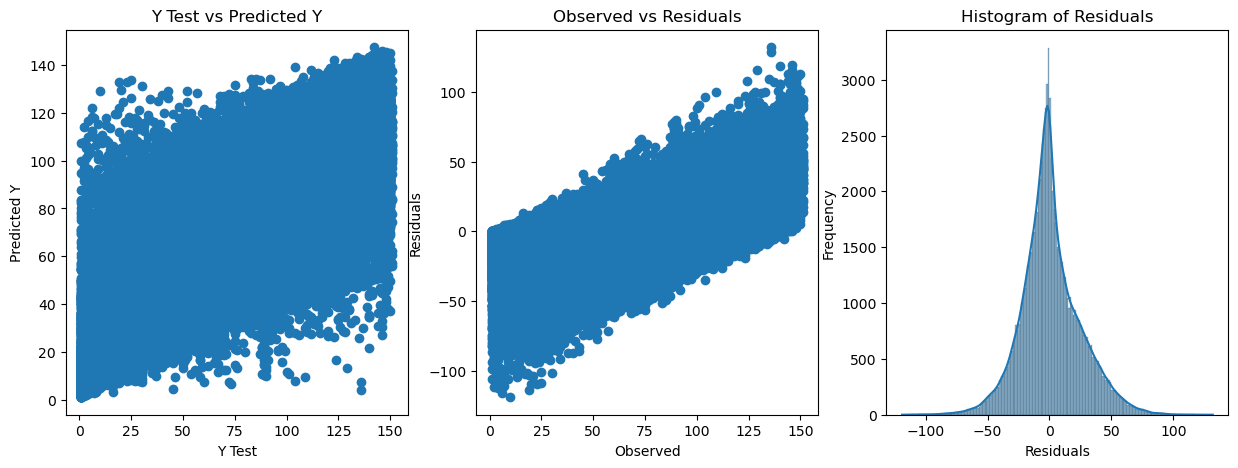

MAE:   17.8046
MSE:   576.8208
RMSE:   24.0171
R2:   0.6753


In [15]:
random_forest = RandomForestRegressor(**space_eval(param_space, best))

random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

print_plots_results('RandomForest with adaBoost', y_test, y_pred)

In [16]:
def website_sort(unsorted_hotels, hotel_names, model):
    sorting = model.predict(unsorted_hotels)
    sorted_hotels = pd.DataFrame()
    sorted_hotels['name'] = hotel_names
    sorted_hotels['sorted_index_in_page'] = sorting
    sorted_hotels.sort_values(by='sorted_index_in_page', ascending=True)
    return sorted_hotels

In [17]:
shuffled_hotels = hotels.sample(frac=1).reset_index(drop=True)

X_test = shuffled_hotels[shuffled_hotels['ttt']%2!=0].drop(['index_in_page'], axis=1)
y_test = shuffled_hotels[shuffled_hotels['ttt']%2!=0]['index_in_page']
convert_date_to_number(X_test, ['start_date_str','end_date_str','snapshot_date'])

In [19]:
hotel_names = le.inverse_transform(X_test['name'])
after_sort = website_sort(X_test, hotel_names ,random_forest)
after_sort['name'] = le.transform(after_sort['name'])

In [20]:
before_sort = pd.DataFrame(columns=['name', 'unsorted_index_in_page'])
before_sort['name'] = X_test['name']
before_sort['unsorted_index_in_page'] = y_test

In [21]:
calculate_error(before_sort, after_sort)

48296705541.0

## Conclussion
#### As we can see the sorting gets a poor result, this combined with the r2 score of the model being low, makes me believe that the data we are dealing with is not quite indicative of the the real life algorithm that the sites are using to sort the hotels